# Praktikum D1 - Regresi dari Citra Sintesis (Prediksi Radius Lingkaran)

## Langkah 1 - Setup & Generator Dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

import tensorflow as tf
from tensorflow.keras import layers, models

# Generator 1 sample
def make_sample(img_size=64, min_r=5, max_r=20):
  r = np.random.randint(min_r, max_r + 1) # radius acak
  img = np.zeros((img_size, img_size), dtype=np.uint8)
  cx = np.random.randint(r, img_size - r) # center-x
  cy = np.random.randint(r, img_size - r) # center-y
  cv2.circle(img, (cx, cy), r, (255,), -1) # lingkaran putih terisi
  img = (img / 255.0).astype(np.float32) # 3-channel biar kompatibel CNN
  img3 = np.stack([img, img, img], axis=-1)
  return img3, float(r), (cx, cy)


## Langkah 2 - "Tebak Apa?" - Tampilkan Contoh Gambar TANPA Label

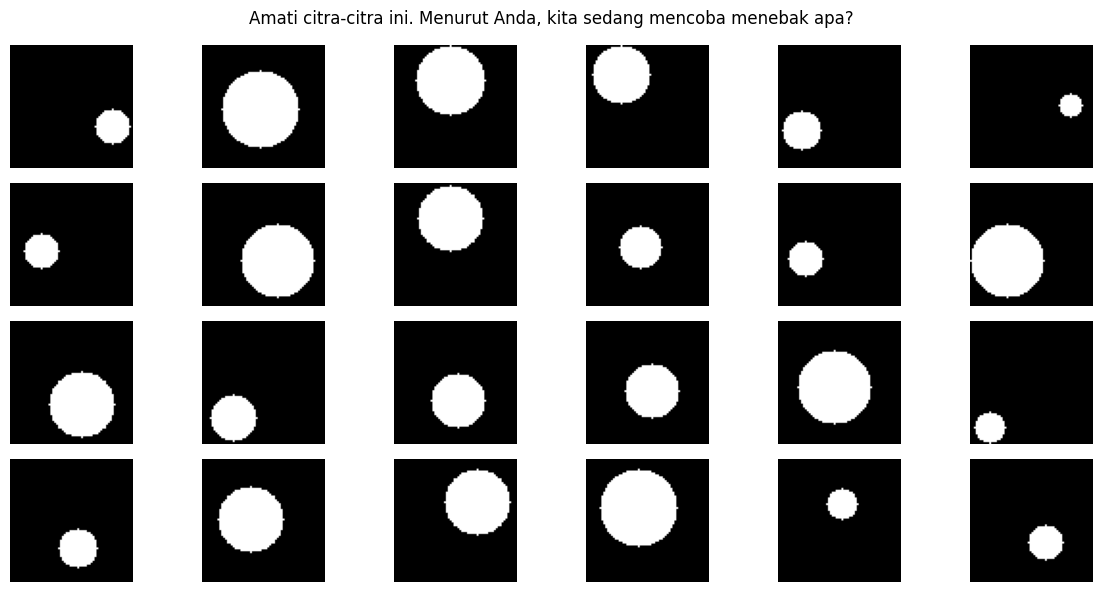

In [2]:
# Buat 24 contoh untuk visualisasi
N_show = 24
samples = [make_sample() for _ in range(N_show)]
imgs = [s[0] for s in samples]
rads = [s[1] for s in samples]
centers = [s[2] for s in samples]

# Grid gambar tanpa label:
cols = 6
rows = N_show // cols
plt.figure(figsize=(12, 6))
for i in range(N_show):
  plt.subplot(rows, cols, i+1)
  plt.imshow(imgs[i].squeeze(), cmap='gray')
  plt.axis('off')
plt.suptitle("Amati citra-citra ini. Menurut Anda, kita sedang mencoba menebak apa?")
plt.tight_layout()
plt.show()



## Langkah 3 - Buka Jawaban - Target yang Ingin Diprediksi

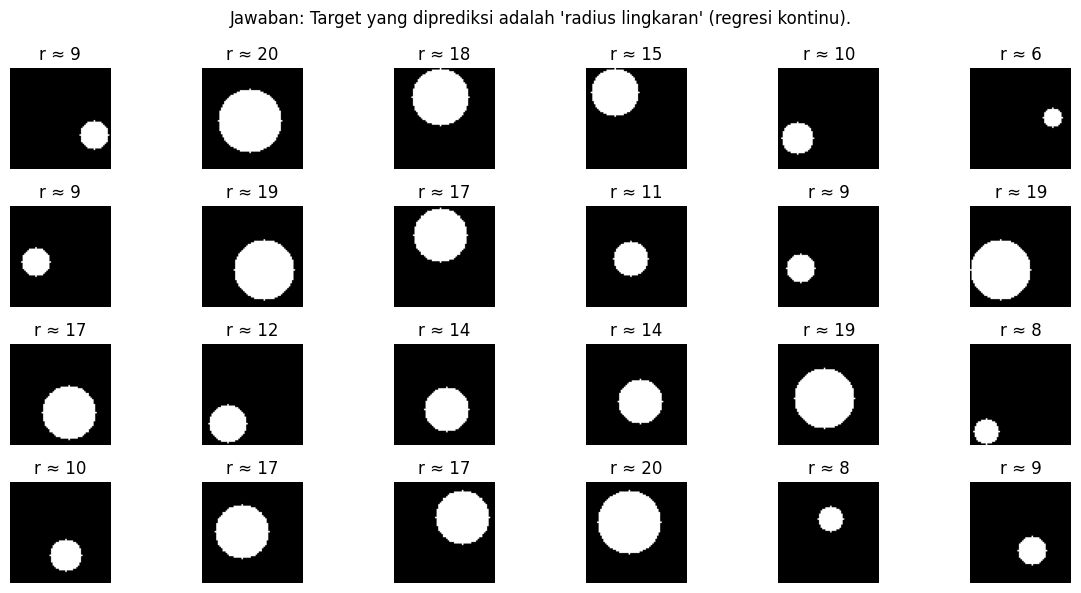

In [3]:
# Tampilkan kembali, sekarang tampilkan radius (label) di judul tiap subplot
plt.figure(figsize=(12, 6))
for i in range(N_show):
  plt.subplot(rows, cols, i+1)
  plt.imshow(imgs[i].squeeze(), cmap='gray')
  plt.title(f"r ≈ {int(rads[i])}")
  plt.axis('off')
plt.suptitle("Jawaban: Target yang diprediksi adalah 'radius lingkaran' (regresi kontinu).")
plt.tight_layout()
plt.show()

## Langkah 4 - (Opsional) Latih CNN kecil untuk Memprediksi Radius

In [4]:
# Siapkan dataset lebih besar untuk training
N = 3000
X, y, C = zip(*[make_sample() for _ in range(N)])
X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.float32)

Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, random_state=42)

# Model CNN sederhana
model = models.Sequential([
    layers.Input((64,64,3)),
    layers.Conv2D(32, 3, activation='relu'), layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'), layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'), layers.Dense(1) # output regresi
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
history = model.fit(Xtr, ytr, validation_data=(Xte, yte),epochs=12, batch_size=64, verbose=0)

# Evaluasi
y_pred = model.predict(Xte).ravel()
mae = mean_absolute_error(yte, y_pred)
rmse = float(np.sqrt(np.mean((yte - y_pred)**2)))
r2 = r2_score(yte, y_pred)
print(f"MAE={mae:.3f} | RMSE={rmse:.3f} | R²={r2:.3f}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
MAE=0.990 | RMSE=1.259 | R²=0.924


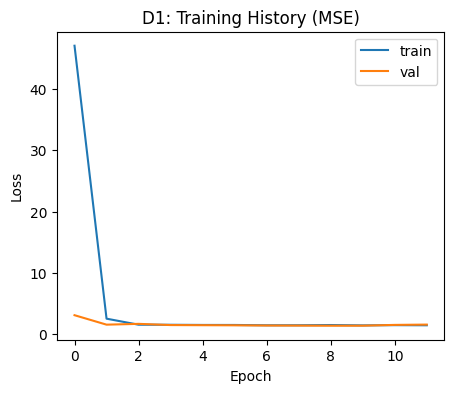

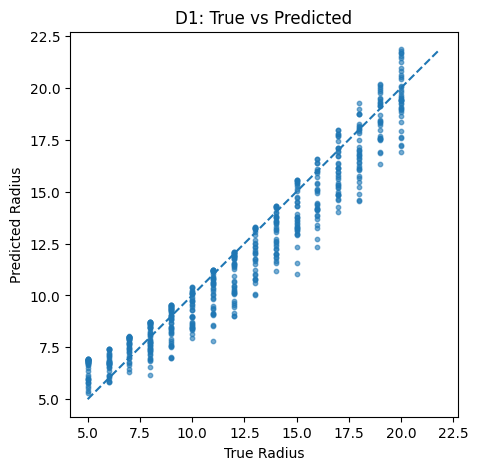

In [5]:
# Plot loss
plt.figure(figsize=(5,4))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title("D1: Training History (MSE)")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.show()

# Scatter True vs Pred
plt.figure(figsize=(5,5))
plt.scatter(yte, y_pred, s=10, alpha=0.6)
lims = [min(yte.min(), y_pred.min()), max(yte.max(), y_pred.max())]
plt.plot(lims, lims, '--')
plt.xlabel("True Radius"); plt.ylabel("Predicted Radius")
plt.title("D1: True vs Predicted")
plt.show()


## 5. Tantangan Mini

In [6]:
# === Ubah rentang radius (mis. 8–28) dan lihat dampaknya ke MAE/RMSE/R² ===
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import math
import tensorflow as tf
from tensorflow.keras import layers, models


N1 = 3000
X1, y1, C1 = zip(*[make_sample(img_size=64, min_r=8, max_r=28) for _ in range(N1)])
X1 = np.array(X1, dtype=np.float32)
y1 = np.array(y1, dtype=np.float32)

X1_tr, X1_te, y1_tr, y1_te = train_test_split(X1, y1, test_size=0.2, random_state=42)

# Model CNN sederhana
model_a = models.Sequential([
    layers.Input((64,64,3)),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])
model_a.compile(optimizer='adam', loss='mse', metrics=['mae'])

history_a = model_a.fit(X1_tr, y1_tr, validation_data=(X1_te, y1_te), epochs=12, batch_size=64, verbose=1)

y1_pred = model_a.predict(X1_te).ravel()
mae_a = mean_absolute_error(y1_te, y1_pred)
rmse_a = float(math.sqrt(np.mean((y1_te - y1_pred)**2)))
r2_a = r2_score(y1_te, y1_pred)

print("=== Eksperimen A (radius 8–28) ===")
print(f"MAE = {mae_a:.3f} | RMSE = {rmse_a:.3f} | R² = {r2_a:.3f}")


Epoch 1/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - loss: 239.8848 - mae: 13.4852 - val_loss: 7.3484 - val_mae: 2.3010
Epoch 2/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 5.1565 - mae: 1.8025 - val_loss: 1.5163 - val_mae: 1.0184
Epoch 3/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.3504 - mae: 0.9589 - val_loss: 1.0950 - val_mae: 0.8482
Epoch 4/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.1399 - mae: 0.8666 - val_loss: 1.0346 - val_mae: 0.8314
Epoch 5/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.0787 - mae: 0.8443 - val_loss: 1.0103 - val_mae: 0.8182
Epoch 6/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.0534 - mae: 0.8370 - val_loss: 0.9840 - val_mae: 0.8060
Epoch 7/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.0392 - mae: 0.8300 - val_loss: 0.9673 - val_mae: 0.7965
Epoch 8/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.0933 - mae: 0.8484 - val_loss: 0.9874 - val_mae: 0.7957
Epoch 9/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.

In [7]:
# === Tambahkan noise (Gaussian + blur) ke citra → observasi performa ===
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import math
import tensorflow as tf
from tensorflow.keras import layers, models
import random

def add_gaussian_noise(img, sigma=10):
    """img: float32 in [0,1], shape (H,W,3)"""
    noise = np.random.normal(0, sigma/255.0, img.shape).astype(np.float32)
    noised = img + noise
    return np.clip(noised, 0.0, 1.0)

def add_gaussian_blur(img, ksize=3):
    """img: float32 in [0,1]"""
    # convert to uint8 for cv2, then back to float
    u = (img * 255).astype(np.uint8)
    b = cv2.GaussianBlur(u, (ksize, ksize), 0)
    return (b.astype(np.float32) / 255.0)

# Generate dataset with original radii range (5-20) but apply random augmentation (noise/blur)
N2 = 3000
X2_clean = []
y2 = []
for _ in range(N2):
    img, r, c = make_sample(img_size=64, min_r=5, max_r=20)
    # randomly decide augmentation
    p = random.random()
    if p < 0.33:
        img = add_gaussian_noise(img, sigma=15)
    elif p < 0.66:
        img = add_gaussian_blur(img, ksize=5)
    else:
        # small chance apply both
        img = add_gaussian_noise(img, sigma=10)
        img = add_gaussian_blur(img, ksize=3)
    X2_clean.append(img)
    y2.append(r)

X2 = np.array(X2_clean, dtype=np.float32)
y2 = np.array(y2, dtype=np.float32)

X2_tr, X2_te, y2_tr, y2_te = train_test_split(X2, y2, test_size=0.2, random_state=42)

# Use same small CNN
model_b = models.Sequential([
    layers.Input((64,64,3)),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])
model_b.compile(optimizer='adam', loss='mse', metrics=['mae'])

history_b = model_b.fit(X2_tr, y2_tr, validation_data=(X2_te, y2_te), epochs=12, batch_size=64, verbose=1)

y2_pred = model_b.predict(X2_te).ravel()
mae_b = mean_absolute_error(y2_te, y2_pred)
rmse_b = float(math.sqrt(np.mean((y2_te - y2_pred)**2)))
r2_b = r2_score(y2_te, y2_pred)

print("=== Eksperimen B (noise/blur augmentasi) ===")
print(f"MAE = {mae_b:.3f} | RMSE = {rmse_b:.3f} | R² = {r2_b:.3f}")


Epoch 1/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - loss: 107.0501 - mae: 8.7540 - val_loss: 9.5084 - val_mae: 2.3418
Epoch 2/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 5.4697 - mae: 1.8365 - val_loss: 3.1387 - val_mae: 1.4425
Epoch 3/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2.7075 - mae: 1.3087 - val_loss: 2.5127 - val_mae: 1.3022
Epoch 4/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2.1063 - mae: 1.1538 - val_loss: 2.3155 - val_mae: 1.2540
Epoch 5/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.9650 - mae: 1.1024 - val_loss: 1.9047 - val_mae: 1.1346
Epoch 6/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.6606 - mae: 1.0311 - val_loss: 1.6407 - val_mae: 1.0483
Epoch 7/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.4451 - mae: 0.9633 - val_loss: 1.5397 - val_mae: 1.0258
Epoch 8/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.2606 - mae: 0.9008 - val_loss: 1.8362 - val_mae: 1.0822
Epoch 9/12
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.5

In [8]:
# === Multi-output: prediksikan [r, cx, cy] sekaligus (multi-output regression) ===
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import math
import tensorflow as tf
from tensorflow.keras import layers, models

# Generate dataset with labels radius, center x, center y
N3 = 4000
X3 = []
Y3 = []
for _ in range(N3):
    img, r, (cx, cy) = make_sample(img_size=64, min_r=5, max_r=20)
    # normalize cx,cy to [0,1]
    Y3.append([r, float(cx), float(cy)])
    X3.append(img)
X3 = np.array(X3, dtype=np.float32)
Y3 = np.array(Y3, dtype=np.float32)

# Option: scale outputs so ranges are comparable (radius ~ 5..20, cx/cy ~ 0..63)
# We'll scale cx,cy to [0,1] to make loss balanced; radius we keep as-is (or scale too).
# Here we scale all outputs: r_scaled = r/64, cx_scaled = cx/64, cy_scaled = cy/64
Y3_scaled = Y3.copy()
Y3_scaled[:,0] = Y3[:,0] / 64.0
Y3_scaled[:,1] = Y3[:,1] / 64.0
Y3_scaled[:,2] = Y3[:,2] / 64.0

X3_tr, X3_te, Y3_tr, Y3_te = train_test_split(X3, Y3_scaled, test_size=0.2, random_state=42)

# Build multi-output CNN
model_c = models.Sequential([
    layers.Input((64,64,3)),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(3)  # outputs: r_scaled, cx_scaled, cy_scaled
])
model_c.compile(optimizer='adam', loss='mse', metrics=['mae'])

history_c = model_c.fit(X3_tr, Y3_tr, validation_data=(X3_te, Y3_te), epochs=12, batch_size=64, verbose=1)

# Predict and unscale for reporting
Y3_pred_scaled = model_c.predict(X3_te)
Y3_pred = Y3_pred_scaled.copy()
Y3_pred[:,0] = Y3_pred_scaled[:,0] * 64.0
Y3_pred[:,1] = Y3_pred_scaled[:,1] * 64.0
Y3_pred[:,2] = Y3_pred_scaled[:,2] * 64.0

Y3_te_unscaled = Y3_te.copy()
Y3_te_unscaled[:,0] = Y3_te[:,0] * 64.0
Y3_te_unscaled[:,1] = Y3_te[:,1] * 64.0
Y3_te_unscaled[:,2] = Y3_te[:,2] * 64.0

# Compute MAE per output
mae_r = mean_absolute_error(Y3_te_unscaled[:,0], Y3_pred[:,0])
mae_cx = mean_absolute_error(Y3_te_unscaled[:,1], Y3_pred[:,1])
mae_cy = mean_absolute_error(Y3_te_unscaled[:,2], Y3_pred[:,2])

# Overall RMSE (combined over all outputs)
rmse_all = math.sqrt(np.mean((Y3_te_unscaled - Y3_pred)**2))

print("=== Eksperimen C (multi-output: r, cx, cy) ===")
print(f"MAE radius (pixels) = {mae_r:.3f}")
print(f"MAE cx (pixels)     = {mae_cx:.3f}")
print(f"MAE cy (pixels)     = {mae_cy:.3f}")
print(f"Combined RMSE (all outputs) = {rmse_all:.3f}")

# Optional: show a few predicted vs true
for i in range(5):
    print(f"Contoh {i+1}: True [r,cx,cy]={Y3_te_unscaled[i].round(1)}  Pred [r,cx,cy]={Y3_pred[i].round(1)}")

Epoch 1/12
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - loss: 0.0666 - mae: 0.1836 - val_loss: 0.0123 - val_mae: 0.0807
Epoch 2/12
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0102 - mae: 0.0735 - val_loss: 0.0067 - val_mae: 0.0597
Epoch 3/12
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0064 - mae: 0.0573 - val_loss: 0.0049 - val_mae: 0.0497
Epoch 4/12
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0052 - mae: 0.0505 - val_loss: 0.0048 - val_mae: 0.0482
Epoch 5/12
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0037 - mae: 0.0419 - val_loss: 0.0030 - val_mae: 0.0390
Epoch 6/12
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0030 - mae: 0.0373 - val_loss: 0.0028 - val_mae: 0.0341
Epoch 7/12
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0028 - mae: 0.0356 - val_loss: 0.0027 - val_mae: 0.0332
Epoch 8/12
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0024 - mae: 0.0316 - val_loss: 0.0030 - val_mae: 0.0367
Epoch 9/12
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.002

# Praktikum D2 - Menebak Umur Manusia dari Foto Wajah (UTKFace)

In [9]:
# Jalankan ini di awal notebook
from google.colab import files
files.upload() # pilih file kaggle.json dari komputer Anda

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"arjunanathapratisena","key":"e1bb1261386440b608dd699e9ffb94ba"}'}

In [10]:
import os, shutil
if os.path.exists("kaggle.json"):
  os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
  shutil.copy("kaggle.json", os.path.expanduser("~/.kaggle/kaggle.json"))
  os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)
  !pip -q install kaggle
  print("✅ Kaggle API siap digunakan.")
else:
  print(" .ı kaggle.json belum ditemukan. Upload terlebih dahulu.")

✅ Kaggle API siap digunakan.


In [11]:
# Unduh dataset UTKFace (sekali saja)
!kaggle datasets download -d jangedoo/utkface-new -p /content -q
!unzip -q /content/utkface-new.zip -d /content/utk
print("✅ Dataset UTKFace berhasil diekstrak.")

Dataset URL: https://www.kaggle.com/datasets/jangedoo/utkface-new
License(s): copyright-authors
✅ Dataset UTKFace berhasil diekstrak.


Total gambar ditemukan: 23708


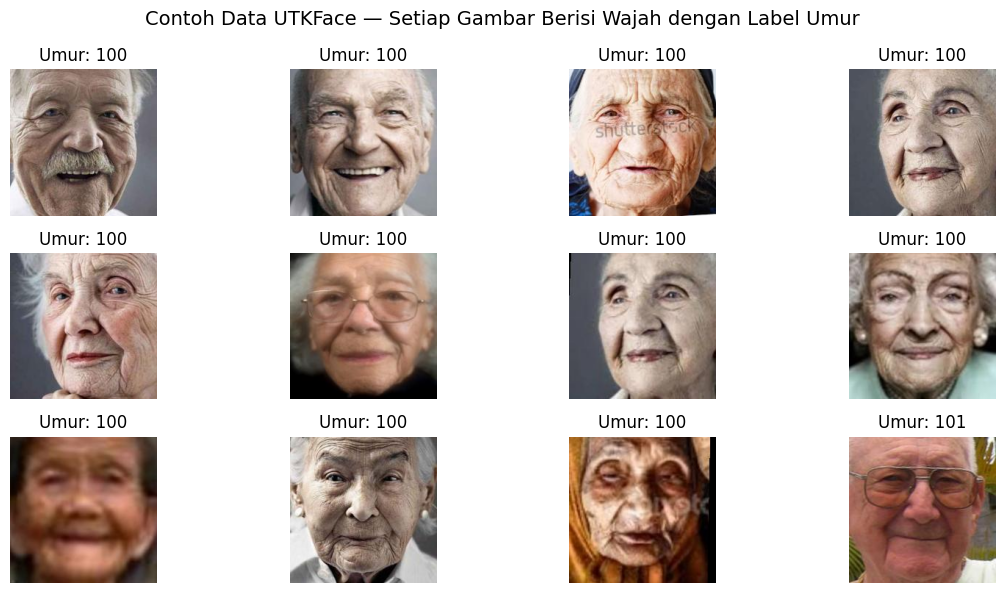

In [12]:
import matplotlib.pyplot as plt
import os, glob
from PIL import Image

# Ambil 12 gambar acak dari dataset
files = glob.glob("/content/utk/UTKFace/*.jpg")
files = sorted(files)
print(f"Total gambar ditemukan: {len(files)}")
plt.figure(figsize=(12, 6))
for i, f in enumerate(files[:12]):
  # Ambil umur dari nama file
  age = int(os.path.basename(f).split("_")[0])
  img = Image.open(f)
  plt.subplot(3, 4, i + 1)
  plt.imshow(img)
  plt.title(f"Umur: {age}")
  plt.axis("off")
plt.suptitle("Contoh Data UTKFace — Setiap Gambar Berisi Wajah dengan Label Umur", fontsize=14)
plt.tight_layout()
plt.show()

## Langkah 5 - Siapkan Dataset untuk Model

In [13]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split

def parse_age_from_name(fp):
  return int(os.path.basename(fp).split('_')[0])

ages = np.array([parse_age_from_name(f) for f in files], dtype=np.float32)
train_files, test_files, y_train, y_test = train_test_split(
    files, ages, test_size=0.2, random_state=42
)

IMG_SIZE = 160
def load_img(fp, label):
  img = tf.io.read_file(fp)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
  return img / 255.0, label

train_ds = tf.data.Dataset.from_tensor_slices((train_files, y_train)).map(load_img).batch(64)
test_ds = tf.data.Dataset.from_tensor_slices((test_files, y_test)).map(load_img).batch(64)

print("✅ Dataset siap dilatih.")

✅ Dataset siap dilatih.


## Langkah 6 - Membangun Model dengan Transfer Learning

In [14]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# Gunakan GPU jika tersedia
print("Hardware:", "GPU" if tf.config.list_physical_devices('GPU') else "CPU")

# Buat arsitektur model
base_model = tf.keras.applications.MobileNetV2(
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights='imagenet'
)
base_model.trainable = False # tahap awal: freeze backbone

# Tambahkan head regresi
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs * 255.0)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(1)(x) # output tunggal: umur
model = tf.keras.Model(inputs, outputs)

# Kompilasi model
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                loss='mse', metrics=['mae'])

model.summary()


Hardware: GPU
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multiply (Multiply)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## Langkah 7 - Melatih Model (Tahap 1 - Frozen)

Epoch 1/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 54s 126ms/step - loss: 341.5193 - mae: 13.5935 - val_loss: 159.6193 - val_mae: 9.6052 - learning_rate: 0.0010
Epoch 2/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - loss: 153.4351 - mae: 9.2090 - val_loss: 148.0799 - val_mae: 9.1571 - learning_rate: 0.0010
Epoch 3/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - loss: 144.9064 - mae: 8.8746 - val_loss: 143.4402 - val_mae: 8.9754 - learning_rate: 0.0010
Epoch 4/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - loss: 141.1033 - mae: 8.7435 - val_loss: 139.9151 - val_mae: 8.8222 - learning_rate: 0.0010
Epoch 5/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - loss: 138.4500 - mae: 8.6329 - val_loss: 136.3430 - val_mae: 8.6163 - learning_rate: 0.0010
Epoch 6/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 22s 50ms/step - loss: 137.5405 - mae: 8.5494 - val_loss: 139.8480 - val_mae: 8.8364 - learning_rate: 0.0010
Epoch 7/10
297/297 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - loss: 136.2950 - mae: 8.5249 - val_loss: 138.1640 - va

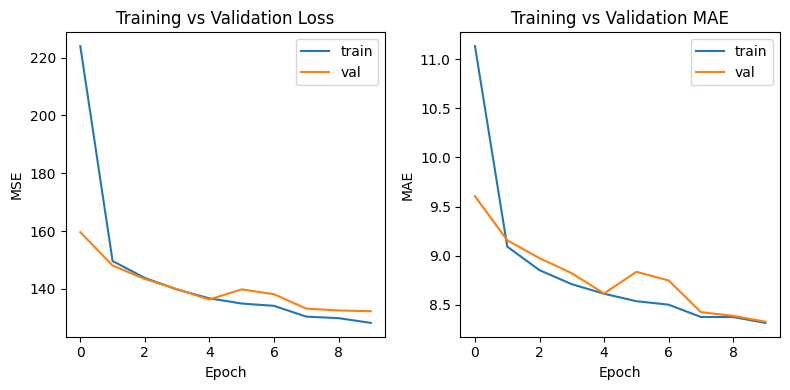

In [15]:
# Callback untuk pelatihan yang lebih stabil
cb = [
  tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True, monitor='val_loss'),
  tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5, min_lr=1e-5, monitor='val_loss')
]

history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=10,
    callbacks=cb,
    verbose=1
)

# Visualisasi perubahan loss dan MAE selama pelatihan:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('Epoch'); plt.ylabel('MSE'); plt.title('Training vs Validation Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['mae'], label='train')
plt.plot(history.history['val_mae'], label='val')
plt.xlabel('Epoch'); plt.ylabel('MAE')
plt.title('Training vs Validation MAE')
plt.legend()
plt.tight_layout()
plt.show()


## Langkah 8 - Fine-tuning Backbone (Tahap 2)

Epoch 1/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 47s 105ms/step - loss: 188.6047 - mae: 10.1069 - val_loss: 155.0196 - val_mae: 9.0160 - learning_rate: 1.0000e-04
Epoch 2/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 48ms/step - loss: 77.8029 - mae: 6.4889 - val_loss: 117.6441 - val_mae: 7.9840 - learning_rate: 1.0000e-04
Epoch 3/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 48ms/step - loss: 50.7824 - mae: 5.3346 - val_loss: 105.9442 - val_mae: 7.5471 - learning_rate: 1.0000e-04
Epoch 4/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 23s 58ms/step - loss: 36.8462 - mae: 4.5892 - val_loss: 105.7785 - val_mae: 7.3009 - learning_rate: 1.0000e-04
Epoch 5/5
297/297 ━━━━━━━━━━━━━━━━━━━━ 14s 47ms/step - loss: 28.0344 - mae: 3.9948 - val_loss: 105.0337 - val_mae: 7.2570 - learning_rate: 1.0000e-04


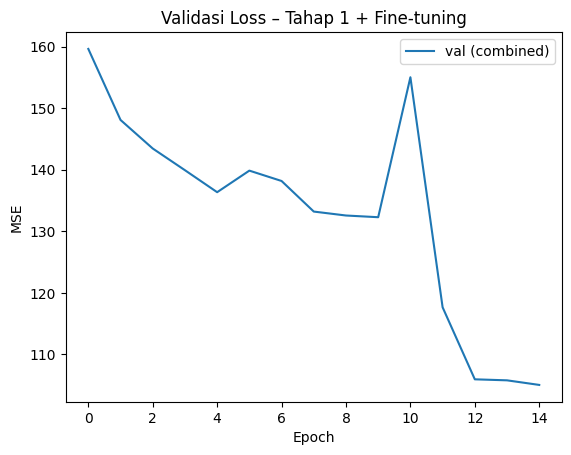

In [16]:
# Aktifkan kembali sebagian layer terakhir untuk fine-tuning
base_model.trainable = True
for layer in base_model.layers[:-30]:
  layer.trainable = False # beku sebagian besar layer

# Recompile dengan learning rate lebih kecil
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                loss='mse', metrics=['mae'])

history_ft = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=5,
    callbacks=cb,
    verbose=1
)

# Visualisasi gabungan training dan fine-tuning:
plt.plot(history.history['val_loss'] + history_ft.history['val_loss'], label='val (combined)')
plt.title("Validasi Loss – Tahap 1 + Fine-tuning")
plt.xlabel("Epoch"); plt.ylabel("MSE")
plt.legend(); plt.show()

## Langkah 9 - Evaluasi Akhir (MAE, RMSE, R^2)

MAE = 7.26 tahun
RMSE = 10.25 tahun
R²	= 0.735


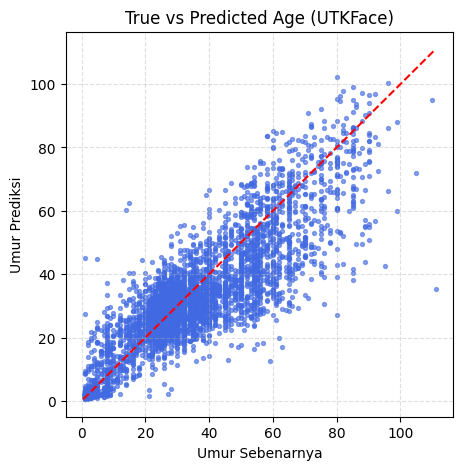

In [17]:
from math import sqrt

y_pred = np.concatenate([model.predict(batch[0], verbose=0).ravel() for batch in test_ds])
mae = mean_absolute_error(y_test, y_pred)
rmse = sqrt(np.mean((y_test - y_pred)**2))
r2 = r2_score(y_test, y_pred)

print(f"MAE = {mae:.2f} tahun")
print(f"RMSE = {rmse:.2f} tahun")
print(f"R²	= {r2:.3f}")

# Plot “umur sebenarnya vs umur prediksi”:
plt.figure(figsize=(5,5))
plt.scatter(y_test, y_pred, s=8, alpha=0.6, color='royalblue')
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, '--', color='red')
plt.xlabel("Umur Sebenarnya")
plt.ylabel("Umur Prediksi")
plt.title("True vs Predicted Age (UTKFace)")
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()


## Langkah 10 - Melihat Contoh Prediksi Nyata

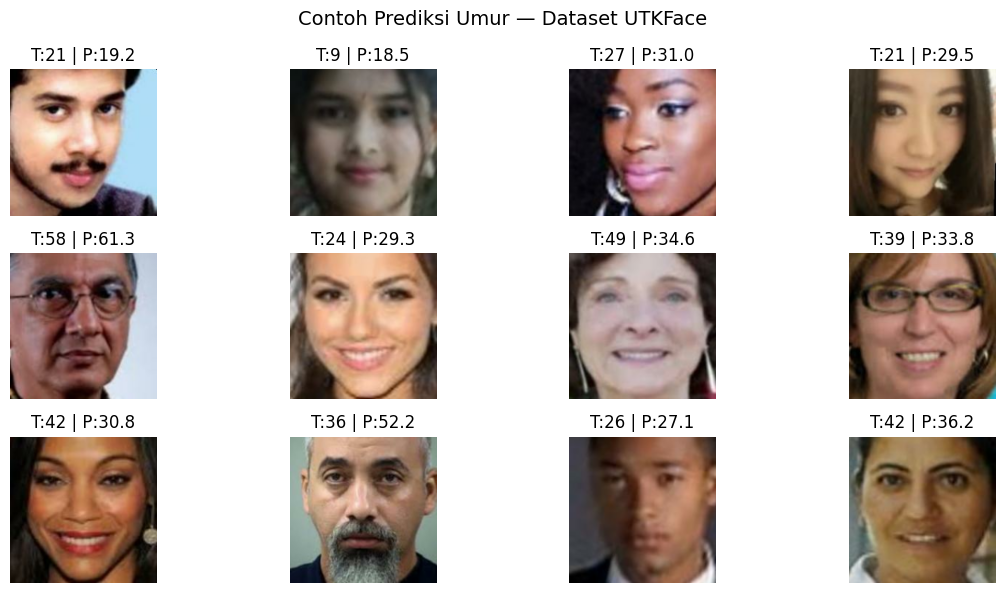

In [18]:
import random
sample_paths = random.sample(test_files, 12)

plt.figure(figsize=(12,6))
for i, path in enumerate(sample_paths):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))/255.0
  true_age = int(os.path.basename(path).split('_')[0])
  pred_age = model.predict(tf.expand_dims(img, 0), verbose=0).ravel()[0]
  plt.subplot(3,4,i+1)
  plt.imshow(img.numpy())
  plt.title(f"T:{true_age} | P:{pred_age:.1f}")
  plt.axis('off')

plt.suptitle("Contoh Prediksi Umur — Dataset UTKFace", fontsize=14)
plt.tight_layout()
plt.show()

## Tantangan Mini

In [19]:
# === Tambahkan data augmentation ekstra (kontras, brightness, zoom)

import tensorflow as tf
import numpy as np
import os, glob
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from sklearn.metrics import mean_absolute_error

# Pastikan fungsi parse_age_from_name dan variabel files (UTKFace) tersedia; jika tidak, buat ulang.
try:
    files
except NameError:
    files = sorted(glob.glob("/content/utk/UTKFace/*.jpg"))

def parse_age_from_name(fp):
    return int(os.path.basename(fp).split('_')[0])

ages = np.array([parse_age_from_name(f) for f in files], dtype=np.float32)
train_files, test_files, y_train, y_test = train_test_split(files, ages, test_size=0.2, random_state=42)

IMG_SIZE = 160

# Fungsi augmentasi: contrast, brightness, random zoom (random crop + resize)
def augment_image(image, label):
    # image: decoded but not normalized (we'll assume float32 [0,1])
    # Random contrast
    image = tf.image.random_contrast(image, lower=0.7, upper=1.3)
    # Random brightness
    image = tf.image.random_brightness(image, max_delta=0.15)
    # Random zoom: perform random crop between 85% - 100% then resize back
    shape = tf.shape(image)
    h = shape[0]
    w = shape[1]
    scale = tf.random.uniform([], 0.85, 1.0)
    new_h = tf.cast(tf.cast(h, tf.float32) * scale, tf.int32)
    new_w = tf.cast(tf.cast(w, tf.float32) * scale, tf.int32)
    image = tf.image.random_crop(image, size=[new_h, new_w, 3])
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = tf.clip_by_value(image, 0.0, 1.0)
    return image, label

def load_and_preprocess(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0
    return img, label

# Dataset tanpa augmentasi (for comparison)
train_ds_orig = tf.data.Dataset.from_tensor_slices((train_files, y_train)) \
    .map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE) \
    .shuffle(2048).batch(64).prefetch(tf.data.AUTOTUNE)

# Dataset dengan augmentasi
train_ds_aug = tf.data.Dataset.from_tensor_slices((train_files, y_train)) \
    .map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE) \
    .map(augment_image, num_parallel_calls=tf.data.AUTOTUNE) \
    .shuffle(2048).batch(64).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((test_files, y_test)) \
    .map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE) \
    .batch(64).prefetch(tf.data.AUTOTUNE)

# Buat model baru (MobileNetV2 backbone)
base_model = tf.keras.applications.MobileNetV2(include_top=False,
                                               input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                               weights='imagenet')
base_model.trainable = False

inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs * 255.0)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(1)(x)
model_aug = tf.keras.Model(inputs, outputs)

model_aug.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss='mse', metrics=['mae'])

# Latih model dengan augmentasi
history_aug = model_aug.fit(train_ds_aug, validation_data=test_ds, epochs=6, verbose=1)

# Evaluasi pada test set
y_pred_aug = np.concatenate([model_aug.predict(batch[0], verbose=0).ravel() for batch in test_ds])
mae_aug = mean_absolute_error(y_test, y_pred_aug)
print(f"[D2-1] MAE dengan augmentasi ekstra (contrast/brightness/zoom): {mae_aug:.2f} tahun")

Epoch 1/6
297/297 ━━━━━━━━━━━━━━━━━━━━ 41s 107ms/step - loss: 344.4401 - mae: 13.8267 - val_loss: 158.1548 - val_mae: 9.4855
Epoch 2/6
297/297 ━━━━━━━━━━━━━━━━━━━━ 23s 71ms/step - loss: 166.3593 - mae: 9.6332 - val_loss: 147.4487 - val_mae: 8.9465
Epoch 3/6
297/297 ━━━━━━━━━━━━━━━━━━━━ 22s 68ms/step - loss: 153.7069 - mae: 9.1976 - val_loss: 144.8298 - val_mae: 8.8602
Epoch 4/6
297/297 ━━━━━━━━━━━━━━━━━━━━ 42s 71ms/step - loss: 147.9120 - mae: 8.9585 - val_loss: 142.1495 - val_mae: 8.6736
Epoch 5/6
297/297 ━━━━━━━━━━━━━━━━━━━━ 24s 75ms/step - loss: 146.3445 - mae: 8.8922 - val_loss: 141.3791 - val_mae: 8.7673
Epoch 6/6
297/297 ━━━━━━━━━━━━━━━━━━━━ 41s 72ms/step - loss: 144.2399 - mae: 8.7913 - val_loss: 151.7315 - val_mae: 9.2323
[D2-1] MAE dengan augmentasi ekstra (contrast/brightness/zoom): 9.23 tahun


In [20]:
# === Ubah learning rate schedule / optimizer ===
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers
from sklearn.metrics import mean_absolute_error

# Reuse train_ds_orig (tanpa augmentasi) dan test_ds
# Jika tidak ada, buat ulang secara defensif
try:
    train_ds_orig
    test_ds
except NameError:
    # fallback: recreate small dataset quickly
    files = sorted(glob.glob("/content/utk/UTKFace/*.jpg"))
    ages = np.array([parse_age_from_name(f) for f in files], dtype=np.float32)
    train_files, test_files, y_train, y_test = train_test_split(files, ages, test_size=0.2, random_state=42)
    def load_and_preprocess(path, label):
        img = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
        img = tf.cast(img, tf.float32) / 255.0
        return img, label
    train_ds_orig = tf.data.Dataset.from_tensor_slices((train_files, y_train)) \
        .map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE) \
        .shuffle(2048).batch(64).prefetch(tf.data.AUTOTUNE)
    test_ds = tf.data.Dataset.from_tensor_slices((test_files, y_test)) \
        .map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE) \
        .batch(64).prefetch(tf.data.AUTOTUNE)

def make_base_model():
    base = tf.keras.applications.MobileNetV2(include_top=False,
                                             input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                             weights='imagenet')
    base.trainable = False
    inp = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = tf.keras.applications.mobilenet_v2.preprocess_input(inp * 255.0)
    x = base(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(128, activation='relu')(x)
    out = layers.Dense(1)(x)
    return tf.keras.Model(inp, out)

histories = {}

# 1) Adam default
m1 = make_base_model()
m1.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss='mse', metrics=['mae'])
hist1 = m1.fit(train_ds_orig, validation_data=test_ds, epochs=6, verbose=1)
y1 = np.concatenate([m1.predict(batch[0], verbose=0).ravel() for batch in test_ds])
mae1 = mean_absolute_error(y_test, y1)
histories['adam'] = (hist1, mae1)
print(f"[D2-2] Adam lr=1e-3 MAE: {mae1:.2f}")

# 2) Adam with ExponentialDecay
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3, decay_steps=1000, decay_rate=0.9)
m2 = make_base_model()
m2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), loss='mse', metrics=['mae'])
hist2 = m2.fit(train_ds_orig, validation_data=test_ds, epochs=6, verbose=1)
y2 = np.concatenate([m2.predict(batch[0], verbose=0).ravel() for batch in test_ds])
mae2 = mean_absolute_error(y_test, y2)
histories['adam_decay'] = (hist2, mae2)
print(f"[D2-2] Adam + ExponentialDecay MAE: {mae2:.2f}")

# 3) SGD with momentum + smaller LR
m3 = make_base_model()
m3.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-2, momentum=0.9), loss='mse', metrics=['mae'])
hist3 = m3.fit(train_ds_orig, validation_data=test_ds, epochs=6, verbose=1)
y3 = np.concatenate([m3.predict(batch[0], verbose=0).ravel() for batch in test_ds])
mae3 = mean_absolute_error(y_test, y3)
histories['sgd_mom'] = (hist3, mae3)
print(f"[D2-2] SGD momentum MAE: {mae3:.2f}")

# Ringkasan kestabilan sederhana: tampilkan val_loss tiap epoch untuk tiap eksperimen
for k, (h, mae_val) in histories.items():
    val_losses = h.history.get('val_loss', [])
    print(f"{k}: val_loss per epoch = {np.round(val_losses, 4).tolist()}  | MAE = {mae_val:.2f}")


Epoch 1/6
297/297 ━━━━━━━━━━━━━━━━━━━━ 39s 95ms/step - loss: 336.9481 - mae: 13.6262 - val_loss: 156.7260 - val_mae: 9.5036
Epoch 2/6
297/297 ━━━━━━━━━━━━━━━━━━━━ 16s 51ms/step - loss: 153.1354 - mae: 9.2676 - val_loss: 145.2287 - val_mae: 9.0374
Epoch 3/6
297/297 ━━━━━━━━━━━━━━━━━━━━ 18s 57ms/step - loss: 146.2225 - mae: 8.9157 - val_loss: 140.2952 - val_mae: 8.8245
Epoch 4/6
297/297 ━━━━━━━━━━━━━━━━━━━━ 19s 53ms/step - loss: 137.8562 - mae: 8.6698 - val_loss: 137.0402 - val_mae: 8.6145
Epoch 5/6
297/297 ━━━━━━━━━━━━━━━━━━━━ 17s 53ms/step - loss: 136.6681 - mae: 8.6200 - val_loss: 136.4130 - val_mae: 8.5031
Epoch 6/6
297/297 ━━━━━━━━━━━━━━━━━━━━ 16s 51ms/step - loss: 134.3549 - mae: 8.4696 - val_loss: 135.1532 - val_mae: 8.3971
[D2-2] Adam lr=1e-3 MAE: 8.40
Epoch 1/6
297/297 ━━━━━━━━━━━━━━━━━━━━ 37s 94ms/step - loss: 343.5927 - mae: 13.7155 - val_loss: 155.7831 - val_mae: 9.3765
Epoch 2/6
297/297 ━━━━━━━━━━━━━━━━━━━━ 16s 50ms/step - loss: 152.6996 - mae: 9.1676 - val_loss: 145.0240 - 

In [21]:
# === Pisahkan dataset per kelompok umur (0–10, 11–20, dst.) dan hitung MAE per kelompok ===

import numpy as np
from sklearn.metrics import mean_absolute_error
import math

# Pastikan y_test and test_files tersedia
try:
    y_test
    test_files
except NameError:
    files = sorted(glob.glob("/content/utk/UTKFace/*.jpg"))
    ages = np.array([parse_age_from_name(f) for f in files], dtype=np.float32)
    _, test_files, _, y_test = train_test_split(files, ages, test_size=0.2, random_state=42)

# Pilih model untuk evaluasi: preferensi model_aug -> m1 -> m2 -> m3
eval_model = None
for candidate in ['model_aug', 'm1', 'm2', 'm3']:
    if candidate in globals():
        eval_model = globals()[candidate]
        break
if eval_model is None:
    raise RuntimeError("Tidak menemukan model terlatih (model_aug/m1/m2/m3). Jalankan sel sebelumnya.")

# Prediksi per sample
import tensorflow as tf
def predict_on_files(model, files_list, batch_size=64):
    preds = []
    for i in range(0, len(files_list), batch_size):
        batch_files = files_list[i:i+batch_size]
        imgs = []
        for p in batch_files:
            img = tf.io.read_file(p)
            img = tf.image.decode_jpeg(img, channels=3)
            img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
            img = tf.cast(img, tf.float32) / 255.0
            imgs.append(img)
        imgs = tf.stack(imgs, axis=0)
        pvals = model.predict(imgs, verbose=0).ravel()
        preds.append(pvals)
    return np.concatenate(preds, axis=0)

y_pred_eval = predict_on_files(eval_model, test_files)

# Buat kelompok umur [0-10], [11-20], ... sampai max umur
max_age = int(max(y_test.max(), y_pred_eval.max()) + 1)
groups = [(i, min(i+9, max_age)) for i in range(0, max_age+1, 10)]

group_stats = []
for (a,b) in groups:
    # pilih indeks yang umurnya dalam [a,b]
    idx = np.where((y_test >= a) & (y_test <= b))[0]
    if len(idx) == 0:
        continue
    mae_g = mean_absolute_error(y_test[idx], y_pred_eval[idx])
    group_stats.append(((a,b), len(idx), mae_g))

# Cetak hasil dan temukan kelompok dengan error terbesar
for (a,b), cnt, mae_g in group_stats:
    print(f"Kelompok {a}-{b}: N={cnt}, MAE={mae_g:.2f} tahun")

worst = max(group_stats, key=lambda x: x[2])
print(f"\n> Kelompok dengan MAE terbesar: {worst[0][0]}-{worst[0][1]} (N={worst[1]}) MAE={worst[2]:.2f} tahun")

Kelompok 0-9: N=602, MAE=8.41 tahun
Kelompok 10-19: N=284, MAE=13.24 tahun
Kelompok 20-29: N=1489, MAE=7.76 tahun
Kelompok 30-39: N=883, MAE=7.42 tahun
Kelompok 40-49: N=438, MAE=8.58 tahun
Kelompok 50-59: N=477, MAE=10.62 tahun
Kelompok 60-69: N=293, MAE=12.03 tahun
Kelompok 70-79: N=135, MAE=14.81 tahun
Kelompok 80-89: N=112, MAE=17.28 tahun
Kelompok 90-99: N=26, MAE=17.87 tahun
Kelompok 100-109: N=1, MAE=16.84 tahun
Kelompok 110-119: N=2, MAE=44.56 tahun

> Kelompok dengan MAE terbesar: 110-119 (N=2) MAE=44.56 tahun


Upload satu gambar wajah (file .jpg/.png).


Saving 20251016_062241(2).jpg to 20251016_062241(2).jpg
Prediksi umur untuk gambar '20251016_062241(2).jpg': 15.9 tahun


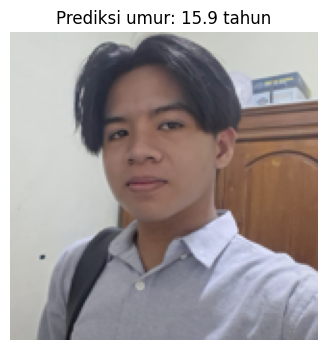

In [22]:
# === Uji model pada wajah sendiri (upload gambar), resize, dan prediksi ===

from google.colab import files
import tensorflow as tf
import numpy as np
from PIL import Image
import io, os

print("Upload satu gambar wajah (file .jpg/.png).")
uploaded = files.upload()

if len(uploaded) == 0:
    print("Tidak ada file yang diupload.")
else:
    # ambil file pertama
    fname = list(uploaded.keys())[0]
    img = Image.open(io.BytesIO(uploaded[fname]))
    img = img.convert('RGB')
    img_resized = img.resize((IMG_SIZE, IMG_SIZE))
    img_arr = np.array(img_resized).astype(np.float32) / 255.0
    input_tensor = tf.expand_dims(img_arr, 0)

    # Pilih model untuk prediksi
    try:
        eval_model
    except NameError:
        eval_model = None
        for candidate in ['model_aug', 'm1', 'm2', 'm3']:
            if candidate in globals():
                eval_model = globals()[candidate]
                break
        if eval_model is None:
            raise RuntimeError("Tidak menemukan model terlatih (model_aug/m1/m2/m3). Jalankan sel pelatihan sebelumnya.")
    pred_val = eval_model.predict(input_tensor, verbose=0).ravel()[0]
    print(f"Prediksi umur untuk gambar '{fname}': {pred_val:.1f} tahun")

    # Tampilkan gambar bersama prediksi
    import matplotlib.pyplot as plt
    plt.figure(figsize=(4,4))
    plt.imshow(img_resized)
    plt.title(f"Prediksi umur: {pred_val:.1f} tahun")
    plt.axis('off')
    plt.show()

# Praktikum D3 - Menilai "Kepopuleran Hewan Peliharaan" dari Foto

## Langkah 1 - Menyiapkan Kaggle API

In [2]:
from google.colab import files
files.upload() # pilih kaggle.json dari komputer Anda
import os, shutil
if os.path.exists("kaggle.json"):
  os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
  shutil.copy("kaggle.json", os.path.expanduser("~/.kaggle/kaggle.json"))
  os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)
  !pip -q install kaggle
  print("✅ Kaggle API siap digunakan.")
else:
  print(" ı. kaggle.json belum ditemukan. Upload terlebih dahulu.")

Saving kaggle.json to kaggle (2).json
✅ Kaggle API siap digunakan.


## Langkah 2 - Mengunduh dan Mengekstrak Dataset

In [3]:
y# Unduh dataset Pawpularity (sekitar 800MB)
!kaggle competitions download -c petfinder-pawpularity-score -p /content -q
!unzip -q /content/petfinder-pawpularity-score.zip -d /content/paw
print("✅ Dataset Pawpularity berhasil diekstrak.")

replace /content/paw/sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/paw/test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: none
replace /content/paw/test/4128bae22183829d2b5fea10effdb0c3.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: none
replace /content/paw/test/43a2262d7738e3d420d453815151079e.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: none all
replace /content/paw/test/4e429cead1848a298432a0acad014c9d.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: all
error:  invalid response [all]
replace /content/paw/test/4e429cead1848a298432a0acad014c9d.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: na
replace /content/paw/test/80bc3ccafcc51b66303c2c263aa38486.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: na
replace /content/paw/test/8f49844c382931444e68dffbe20228f4.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: ✅ Dataset Pawpularity berhasil diekstrak.


## Langkah 3 - Melihat Contoh Data

                                 Id  Subject Focus  Eyes  Face  Near  Action  \
0  0007de18844b0dbbb5e1f607da0606e0              0     1     1     1       0   
1  0009c66b9439883ba2750fb825e1d7db              0     1     1     0       0   
2  0013fd999caf9a3efe1352ca1b0d937e              0     1     1     1       0   
3  0018df346ac9c1d8413cfcc888ca8246              0     1     1     1       0   
4  001dc955e10590d3ca4673f034feeef2              0     0     0     1       0   

   Accessory  Group  Collage  Human  Occlusion  Info  Blur  Pawpularity  \
0          0      1        0      0          0     0     0           63   
1          0      0        0      0          0     0     0           42   
2          0      0        0      1          1     0     0           28   
3          0      0        0      0          0     0     0           15   
4          0      1        0      0          0     0     0           72   

                                                path  
0  /content/p

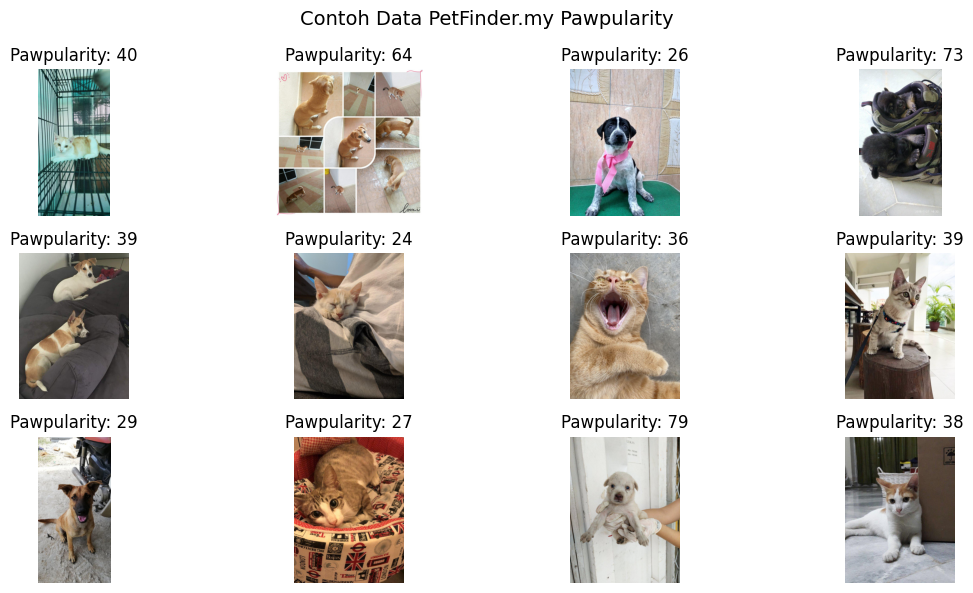

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image

# Muat CSV
df = pd.read_csv('/content/paw/train.csv')
df['path'] = df['Id'].apply(lambda x: f"/content/paw/train/{x}.jpg")
print(df.head())

# Tampilkan 12 contoh gambar
plt.figure(figsize=(12, 6))
for i, row in enumerate(df.sample(12, random_state=42).itertuples()):
  img = Image.open(row.path)
  plt.subplot(3, 4, i + 1)
  plt.imshow(img)
  plt.title(f"Pawpularity: {row.Pawpularity}")
  plt.axis('off')
plt.suptitle("Contoh Data PetFinder.my Pawpularity", fontsize=14)
plt.tight_layout()
plt.show()

## Langkah 4 - Persiapan Dataset

In [5]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

IMG_SIZE = 224
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

def load_image(path, label):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
  img = tf.cast(img, tf.float32) / 255.0
  return img, tf.cast(label, tf.float32)

train_ds = tf.data.Dataset.from_tensor_slices((train_df['path'],
train_df['Pawpularity']))\
    .map(load_image, num_parallel_calls=tf.data.AUTOTUNE)\
    .shuffle(4096).batch(64).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((val_df['path'],
val_df['Pawpularity']))\
    .map(load_image, num_parallel_calls=tf.data.AUTOTUNE)\
    .batch(64).prefetch(tf.data.AUTOTUNE)

print(f"Dataset siap digunakan — {len(train_df)} untuk training, {len(val_df)} untuk validasi.")

Dataset siap digunakan — 7929 untuk training, 1983 untuk validasi.


## Langkah 5 - Membangun Model (EfficientNetB0)

In [6]:
from tensorflow.keras import layers, models

base = tf.keras.applications.EfficientNetB0(
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights='imagenet'
)
base.trainable = False # freeze sementara

inputs = tf.keras.Input((IMG_SIZE, IMG_SIZE, 3))
x = tf.keras.applications.efficientnet.preprocess_input(inputs * 255.0)
x = base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='relu')(x)
outputs = layers.Dense(1)(x)

model = tf.keras.Model(inputs, outputs)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multiply (Multiply)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,377,764 (16.70 MB)

 Trainable params: 328,193 (1.25 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

## Langkah 6 - Melatih Model

In [7]:
cb = [
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.5)
]

history = model.fit(train_ds, validation_data=val_ds, epochs=10, callbacks=cb, verbose=1)

Epoch 1/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 112s 524ms/step - loss: 856.9071 - mae: 21.9778 - val_loss: 478.9971 - val_mae: 16.1041 - learning_rate: 0.0010
Epoch 2/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 39s 207ms/step - loss: 435.6549 - mae: 15.5032 - val_loss: 429.3664 - val_mae: 15.3630 - learning_rate: 0.0010
Epoch 3/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 39s 203ms/step - loss: 394.7272 - mae: 14.7719 - val_loss: 405.2740 - val_mae: 14.8039 - learning_rate: 0.0010
Epoch 4/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 40s 192ms/step - loss: 377.7950 - mae: 14.4168 - val_loss: 390.3762 - val_mae: 14.6190 - learning_rate: 0.0010
Epoch 5/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 38s 200ms/step - loss: 364.5869 - mae: 14.1809 - val_loss: 380.2634 - val_mae: 14.4021 - learning_rate: 0.0010
Epoch 6/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 46s 237ms/step - loss: 339.7732 - mae: 13.7346 - val_loss: 371.8369 - val_mae: 14.2942 - learning_rate: 0.0010
Epoch 7/10
124/124 ━━━━━━━━━━━━━━━━━━━━ 38s 205ms/step - loss: 332.0684 - mae: 13.5531 - val_

## Langkah 7 - Melihat Proses Belajar

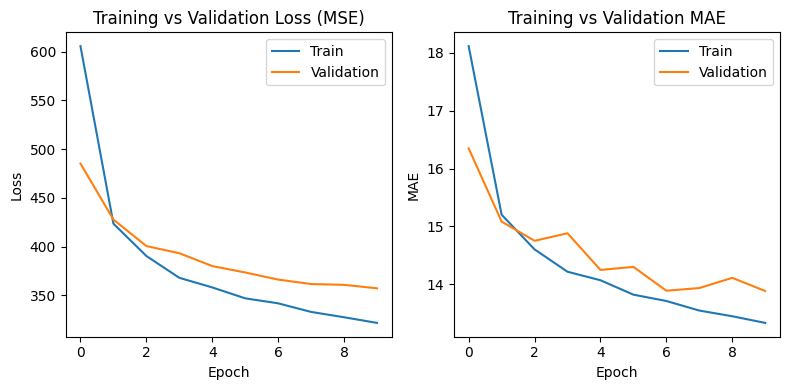

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title("Training vs Validation Loss (MSE)")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['mae'], label='Train')
plt.plot(history.history['val_mae'], label='Validation')
plt.title("Training vs Validation MAE")
plt.xlabel("Epoch"); plt.ylabel("MAE"); plt.legend()
plt.tight_layout()
plt.show()

## Langkah 8 - Evaluasi Model

MAE = 13.88
RMSE = 18.90
R²	= 0.192


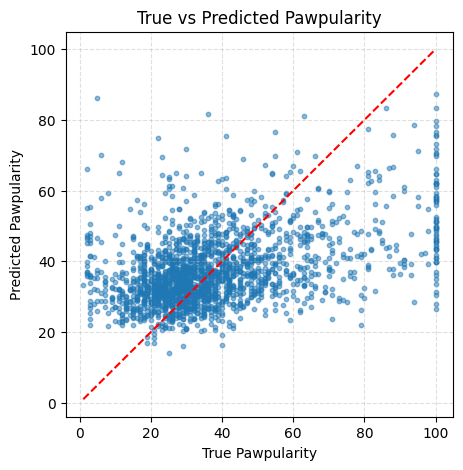

In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score
from math import sqrt

y_true = val_df['Pawpularity'].values.astype(np.float32)
y_pred = np.concatenate([model.predict(batch[0], verbose=0).ravel() for batch in val_ds])

mae = mean_absolute_error(y_true, y_pred)
rmse = sqrt(np.mean((y_true - y_pred)**2))
r2 = r2_score(y_true, y_pred)

print(f"MAE = {mae:.2f}")
print(f"RMSE = {rmse:.2f}")
print(f"R²	= {r2:.3f}")

# Plot hasil prediksi vs nilai sebenarnya:
plt.figure(figsize=(5,5))
plt.scatter(y_true, y_pred, s=10, alpha=0.5)
lims = [min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())]
plt.plot(lims, lims, '--', color='red')
plt.xlabel("True Pawpularity")
plt.ylabel("Predicted Pawpularity")
plt.title("True vs Predicted Pawpularity")
plt.grid(True, linestyle='--', alpha=0.4)
plt.show()

## Langkah 9 - Melihat Contoh Prediksi

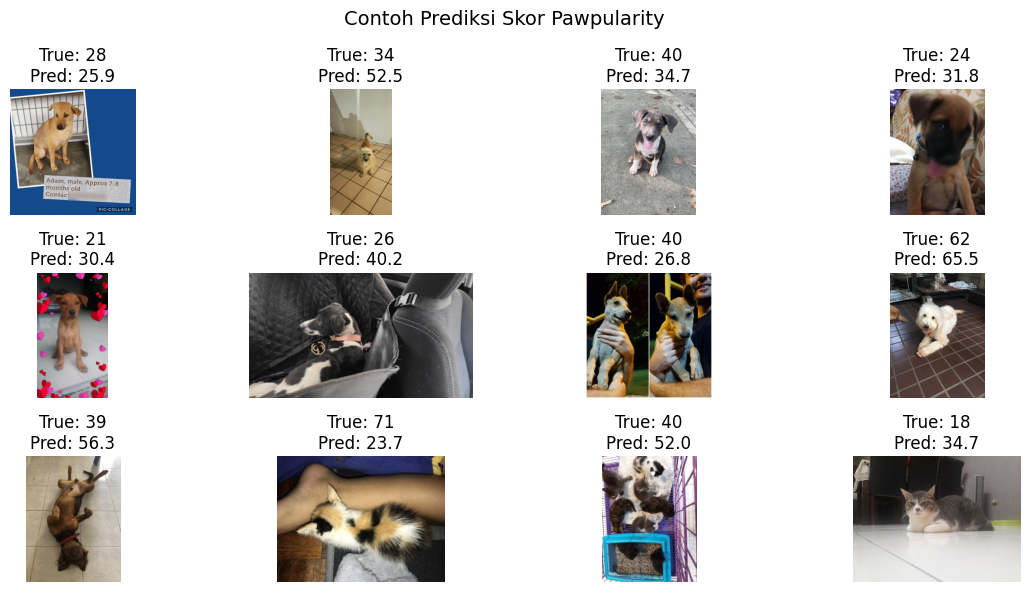

In [ ]:
import random
from PIL import Image

sample_rows = val_df.sample(12, random_state=1)

plt.figure(figsize=(12,6))
for i, row in enumerate(sample_rows.itertuples()):
    img = Image.open(row.path)
    pred = model.predict(tf.expand_dims(load_image(row.path,
    row.Pawpularity)[0], 0), verbose=0).ravel()[0]
    plt.subplot(3,4,i+1)
    plt.imshow(img)
    plt.title(f"True: {row.Pawpularity}\nPred: {pred:.1f}")
    plt.axis('off')
plt.suptitle("Contoh Prediksi Skor Pawpularity", fontsize=14)
plt.tight_layout()
plt.show()

## Tantangan Mini

In [ ]:
# === Data Augmentation

import os, numpy as np, pandas as pd, tensorflow as tf
from sklearn.model_selection import train_test_split

CSV_PATH = '/content/paw/train.csv'
IMG_DIR = '/content/paw/train'

if not os.path.exists(CSV_PATH) or not os.path.exists(IMG_DIR):
    raise RuntimeError("Dataset Pawpularity tidak ditemukan di /content/paw. Jalankan sel unduh/ekstrak dataset terlebih dahulu.")

df_paw = pd.read_csv(CSV_PATH)
df_paw['path'] = df_paw['Id'].apply(lambda x: os.path.join(IMG_DIR, f"{x}.jpg"))
df_paw = df_paw[df_paw['path'].apply(os.path.exists)].reset_index(drop=True)
print(f"Jumlah gambar tersedia: {len(df_paw)}")

# split
train_df_paw, val_df_paw = train_test_split(df_paw, test_size=0.2, random_state=42)
IMG_SIZE = 224
BATCH = 32

# preprocessing
def load_image_paw(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0
    return img, tf.cast(label, tf.float32)

# augmentation: contrast, brightness, random zoom/crop
def aug_paw(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_contrast(image, 0.75, 1.25)
    image = tf.image.random_brightness(image, 0.12)
    # random zoom: central crop with random scale then resize
    scale = tf.random.uniform([], 0.85, 1.0)
    shape = tf.shape(image)
    new_h = tf.cast(tf.cast(shape[0], tf.float32) * scale, tf.int32)
    new_w = tf.cast(tf.cast(shape[1], tf.float32) * scale, tf.int32)
    image = tf.image.random_crop(image, size=[new_h, new_w, 3])
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = tf.clip_by_value(image, 0.0, 1.0)
    return image, label

# Datasets
train_ds_paw = tf.data.Dataset.from_tensor_slices((train_df_paw['path'].values, train_df_paw['Pawpularity'].values)) \
    .map(load_image_paw, num_parallel_calls=tf.data.AUTOTUNE) \
    .shuffle(4096).batch(BATCH).prefetch(tf.data.AUTOTUNE)

train_ds_paw_aug = tf.data.Dataset.from_tensor_slices((train_df_paw['path'].values, train_df_paw['Pawpularity'].values)) \
    .map(load_image_paw, num_parallel_calls=tf.data.AUTOTUNE) \
    .map(aug_paw, num_parallel_calls=tf.data.AUTOTUNE) \
    .shuffle(4096).batch(BATCH).prefetch(tf.data.AUTOTUNE)

val_ds_paw = tf.data.Dataset.from_tensor_slices((val_df_paw['path'].values, val_df_paw['Pawpularity'].values)) \
    .map(load_image_paw, num_parallel_calls=tf.data.AUTOTUNE) \
    .batch(BATCH).prefetch(tf.data.AUTOTUNE)

print("Datasets siap:")
print(" - train (no aug)  :", len(train_df_paw))
print(" - train (aug)     :", len(train_df_paw))
print(" - val             :", len(val_df_paw))


Jumlah gambar tersedia: 9912
Datasets siap:
 - train (no aug)  : 7929
 - train (aug)     : 7929
 - val             : 1983


In [ ]:
# === Bandingkan EfficientNetB3 vs ResNet50
# Latih singkat tiap backbone (gunakan train_ds_paw_aug), catat Val MAE, lalu pilih model terbaik.

import time
import numpy as np
from sklearn.metrics import mean_absolute_error
import tensorflow as tf
from tensorflow.keras import layers

# util: build model dengan backbone pilihan
def build_regression_model(backbone='efficientnetb3', img_size=IMG_SIZE):
    inp = tf.keras.Input(shape=(img_size,img_size,3))
    if 'efficientnet' in backbone:
        # fallback ke B0 jika B3 tidak tersedia
        try:
            pre = tf.keras.applications.efficientnet.preprocess_input(inp * 255.0)
            base = tf.keras.applications.EfficientNetB3(include_top=False, input_tensor=pre, weights='imagenet')
        except Exception:
            pre = tf.keras.applications.efficientnet.preprocess_input(inp * 255.0)
            base = tf.keras.applications.EfficientNetB0(include_top=False, input_tensor=pre, weights='imagenet')
    elif 'resnet' in backbone:
        pre = tf.keras.applications.resnet.preprocess_input(inp * 255.0)
        base = tf.keras.applications.ResNet50(include_top=False, input_tensor=pre, weights='imagenet')
    else:
        raise ValueError("Backbone unknown")
    base.trainable = False
    x = base.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(256, activation='relu')(x)
    out = layers.Dense(1)(x)
    model = tf.keras.Model(inp, out)
    return model

def train_and_eval(backbone_name, train_ds, val_ds, epochs=4):
    print(f"\n=== Training {backbone_name} ===")
    model = build_regression_model(backbone_name)
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss='mse', metrics=['mae'])
    t0 = time.time()
    history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, verbose=1)
    t1 = time.time()
    # preds on validation
    y_true = np.concatenate([y.numpy() for x,y in val_ds], axis=0)
    y_pred = np.concatenate([model.predict(x, verbose=0).ravel() for x,y in val_ds], axis=0)
    mae = mean_absolute_error(y_true, y_pred)
    print(f"{backbone_name} finished in {int(t1-t0)}s | Val MAE = {mae:.2f}")
    return model, history, mae

# Gunakan augmentasi train_ds_paw_aug
model_e3, hist_e3, mae_e3 = train_and_eval('efficientnetb3', train_ds_paw_aug, val_ds_paw, epochs=4)
model_r50, hist_r50, mae_r50 = train_and_eval('resnet50', train_ds_paw_aug, val_ds_paw, epochs=4)

print("\n--- Ringkasan Perbandingan ---")
print(f"EfficientNetB3 (atau fallback B0) MAE: {mae_e3:.3f}")
print(f"ResNet50 MAE: {mae_r50:.3f}")

# tetapkan model terbaik untuk sel berikutnya
best_reg_model = model_e3 if mae_e3 <= mae_r50 else model_r50
print("Model terbaik dipakai di sel berikutnya:", "efficientnetb3 (atau fallback)" if best_reg_model is model_e3 else "resnet50")



=== Training efficientnetb3 ===
Epoch 1/4
248/248 ━━━━━━━━━━━━━━━━━━━━ 129s 286ms/step - loss: 790.5410 - mae: 20.9044 - val_loss: 441.8339 - val_mae: 15.3576
Epoch 2/4
248/248 ━━━━━━━━━━━━━━━━━━━━ 49s 134ms/step - loss: 409.6589 - mae: 14.9512 - val_loss: 390.1785 - val_mae: 14.4812
Epoch 3/4
248/248 ━━━━━━━━━━━━━━━━━━━━ 47s 131ms/step - loss: 380.6848 - mae: 14.5498 - val_loss: 375.5308 - val_mae: 14.4594
Epoch 4/4
248/248 ━━━━━━━━━━━━━━━━━━━━ 46s 127ms/step - loss: 354.1329 - mae: 14.0964 - val_loss: 368.2423 - val_mae: 14.1535
efficientnetb3 finished in 271s | Val MAE = 14.15

=== Training resnet50 ===
Epoch 1/4
248/248 ━━━━━━━━━━━━━━━━━━━━ 71s 182ms/step - loss: 490.4251 - mae: 16.4162 - val_loss: 395.9338 - val_mae: 15.1772
Epoch 2/4
248/248 ━━━━━━━━━━━━━━━━━━━━ 54s 155ms/step - loss: 375.5968 - mae: 14.4079 - val_loss: 374.9823 - val_mae: 14.2943
Epoch 3/4
248/248 ━━━━━━━━━━━━━━━━━━━━ 50s 142ms/step - loss: 351.4936 - mae: 13.9299 - val_loss: 372.0197 - val_mae: 14.3935
Epoch 4

In [ ]:
# === Pisahkan anjing vs kucing (pseudo-label via MobileNetV2) dan ukur MAE per species

import os, numpy as np, pandas as pd, tensorflow as tf
from tensorflow.keras.applications import mobilenet_v2
from tensorflow.keras.applications.mobilenet_v2 import decode_predictions
from sklearn.metrics import mean_absolute_error
from collections import defaultdict

CSV_PAW_WITH_SPECIES = '/content/paw/paw_with_species.csv'
if os.path.exists(CSV_PAW_WITH_SPECIES):
    df_species = pd.read_csv(CSV_PAW_WITH_SPECIES)
    print("Found existing pseudo-labels:", CSV_PAW_WITH_SPECIES)
else:
    print("Creating pseudo-labels using MobileNetV2 (ImageNet) — ini bisa memakan beberapa menit.")
    df_tmp = pd.read_csv('/content/paw/train.csv')
    df_tmp['path'] = df_tmp['Id'].apply(lambda x: os.path.join('/content/paw/train', f"{x}.jpg"))
    df_tmp = df_tmp[df_tmp['path'].apply(os.path.exists)].reset_index(drop=True)
    imagenet = mobilenet_v2.MobileNetV2(weights='imagenet')
    species_list = []
    batch_paths = []
    for i, p in enumerate(df_tmp['path'].values):
        batch_paths.append(p)
        if len(batch_paths) == 64 or i == len(df_tmp)-1:
            imgs = []
            for q in batch_paths:
                img = tf.io.read_file(q)
                img = tf.image.decode_jpeg(img, channels=3)
                img = tf.image.resize(img, (224,224))
                img = tf.cast(img, tf.float32) / 255.0
                imgs.append(img)
            x = tf.stack(imgs, 0)
            x = mobilenet_v2.preprocess_input(x * 255.0)
            preds = imagenet.predict(x, verbose=0)
            decs = decode_predictions(preds, top=5)
            for dec in decs:
                names = [t[1].lower() for t in dec]
                is_cat = any('cat' in n or 'tabby' in n or 'tiger_cat' in n or 'egyptian_cat' in n or 'persian' in n for n in names)
                is_dog = any('dog' in n or 'hound' in n or 'terrier' in n or 'retriever' in n or 'pug' in n or 'spaniel' in n for n in names)
                if is_cat:
                    species_list.append('cat')
                elif is_dog:
                    species_list.append('dog')
                else:
                    species_list.append('other')
            batch_paths = []
    df_tmp['species'] = species_list
    df_tmp.to_csv(CSV_PAW_WITH_SPECIES, index=False)
    df_species = df_tmp
    print("Saved pseudo-labels to", CSV_PAW_WITH_SPECIES)

# Filter dog/cat only
df_dc = df_species[df_species['species'].isin(['dog','cat'])].reset_index(drop=True)
print("Jumlah dog/cat (pseudo):", len(df_dc))
if len(df_dc) == 0:
    raise RuntimeError("Tidak ada contoh dog/cat menurut pseudo-labels — periksa file CSV pseudo-labels.")

# gunakan best_reg_model (harus ada dari sel 2)
try:
    best_reg_model
except NameError:
    # fallback: if model_e3 exists pick it, else model_r50
    if 'model_e3' in globals():
        best_reg_model = model_e3
    elif 'model_r50' in globals():
        best_reg_model = model_r50
    else:
        best_reg_model = None

if best_reg_model is None:
    raise RuntimeError("Tidak menemukan model regresi terlatih (jalankan Sel 2 terlebih dahulu).")

# predict in batches
def predict_on_paths(model, paths, batch_size=64):
    preds = []
    for i in range(0, len(paths), batch_size):
        chunk = paths[i:i+batch_size]
        imgs = []
        for p in chunk:
            img = tf.io.read_file(p)
            img = tf.image.decode_jpeg(img, channels=3)
            img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
            img = tf.cast(img, tf.float32) / 255.0
            imgs.append(img)
        x = tf.stack(imgs, 0)
        preds.append(model.predict(x, verbose=0).ravel())
    return np.concatenate(preds, axis=0)

paths = df_dc['path'].values
y_true = df_dc['Pawpularity'].values.astype(np.float32)
y_pred = predict_on_paths(best_reg_model, paths, batch_size=64)
species = df_dc['species'].values

# MAE per species
stats = defaultdict(list)
for s, t, p in zip(species, y_true, y_pred):
    stats[s].append((t,p))

print("\nMAE per species (dog / cat):")
for sp in ('dog','cat'):
    items = stats.get(sp, [])
    if not items:
        print(f"  {sp}: no samples")
        continue
    t = np.array([it[0] for it in items])
    p = np.array([it[1] for it in items])
    mae_sp = mean_absolute_error(t, p)
    print(f"  {sp}: N={len(items)}  MAE={mae_sp:.2f}")

if 'dog' in stats and 'cat' in stats:
    mae_dog = mean_absolute_error(np.array([it[0] for it in stats['dog']]), np.array([it[1] for it in stats['dog']]))
    mae_cat = mean_absolute_error(np.array([it[0] for it in stats['cat']]), np.array([it[1] for it in stats['cat']]))
    print(f"\nPerbandingan (MAE dog - MAE cat) = {mae_dog - mae_cat:.2f} (positif => dog lebih buruk)")


Creating pseudo-labels using MobileNetV2 (ImageNet) — ini bisa memakan beberapa menit.
Saved pseudo-labels to /content/paw/paw_with_species.csv
Jumlah dog/cat (pseudo): 8984

MAE per species (dog / cat):
  dog: N=4132  MAE=14.89
  cat: N=4852  MAE=12.01

Perbandingan (MAE dog - MAE cat) = 2.87 (positif => dog lebih buruk)


In [ ]:
# === Tambahkan fitur non-visual (brightness rata-rata) ke model regresi (multi-input)

import numpy as np, tensorflow as tf
from tensorflow.keras import layers, Model
from sklearn.metrics import mean_absolute_error

# helper: load image and brightness
def load_img_and_brightness_paw(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0
    gray = tf.image.rgb_to_grayscale(img)
    bright = tf.reduce_mean(gray)  # scalar
    return (img, bright), tf.cast(label, tf.float32)

train_ds_nv = tf.data.Dataset.from_tensor_slices((train_df_paw['path'].values, train_df_paw['Pawpularity'].values)) \
    .map(load_img_and_brightness_paw, num_parallel_calls=tf.data.AUTOTUNE) \
    .shuffle(4096).batch(BATCH).prefetch(tf.data.AUTOTUNE)

val_ds_nv = tf.data.Dataset.from_tensor_slices((val_df_paw['path'].values, val_df_paw['Pawpularity'].values)) \
    .map(load_img_and_brightness_paw, num_parallel_calls=tf.data.AUTOTUNE) \
    .batch(BATCH).prefetch(tf.data.AUTOTUNE)

# build multi-input model (EfficientNetB0 backbone for memory safety)
def build_multiinput(backbone='efficientnetb0'):
    img_in = layers.Input(shape=(IMG_SIZE,IMG_SIZE,3), name='img_in')
    bright_in = layers.Input(shape=(), name='bright_in')
    if 'resnet' in backbone:
        pre = tf.keras.applications.resnet.preprocess_input(img_in * 255.0)
        base = tf.keras.applications.ResNet50(include_top=False, input_tensor=pre, weights='imagenet')
    else:
        pre = tf.keras.applications.efficientnet.preprocess_input(img_in * 255.0)
        base = tf.keras.applications.EfficientNetB0(include_top=False, input_tensor=pre, weights='imagenet')
    base.trainable = False
    x = base.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    b = layers.Reshape((1,))(bright_in)
    b = layers.Dense(8, activation='relu')(b)
    concat = layers.Concatenate()([x, b])
    h = layers.Dense(128, activation='relu')(concat)
    out = layers.Dense(1)(h)
    model = Model([img_in, bright_in], out)
    return model

model_multi = build_multiinput('efficientnetb0')
model_multi.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss='mse', metrics=['mae'])
model_multi.summary()

# train short
hist_multi = model_multi.fit(train_ds_nv, validation_data=val_ds_nv, epochs=4, verbose=1)

# evaluate MAE on validation set
y_true_val = np.concatenate([y.numpy() for (x,y) in val_ds_nv], axis=0)
# prepare preds
preds = []
for (x_batch, y_batch) in val_ds_nv:
    imgs = x_batch[0]  # image
    brs = x_batch[1]   # brightness
    p = model_multi.predict([imgs, brs], verbose=0).ravel()
    preds.append(p)
y_pred_val = np.concatenate(preds, axis=0)
mae_multi = mean_absolute_error(y_true_val, y_pred_val)
print(f"[Sel 4] MAE multi-input (image + avg_brightness): {mae_multi:.2f}")


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ img_in (InputLayer) │ (None, 224, 224,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_4          │ (None, 224, 224,  │          0 │ img_in[0][0]      │
│ (Multiply)          │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_4         │ (None, 224, 224,  │          0 │ multiply_4[0][0]  │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_2     │ (None, 224, 224,  │          7 │ rescaling_4[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_5         │ (None, 224, 224,  │          0 │ normalization_2[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_5[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati

 Total params: 4,231,220 (16.14 MB)

 Trainable params: 181,649 (709.57 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

Epoch 1/4
248/248 ━━━━━━━━━━━━━━━━━━━━ 111s 278ms/step - loss: 716.0627 - mae: 20.0400 - val_loss: 375.4849 - val_mae: 14.2646
Epoch 2/4
248/248 ━━━━━━━━━━━━━━━━━━━━ 53s 141ms/step - loss: 337.8342 - mae: 13.6834 - val_loss: 360.7424 - val_mae: 14.3670
Epoch 3/4
248/248 ━━━━━━━━━━━━━━━━━━━━ 56s 145ms/step - loss: 318.2200 - mae: 13.1659 - val_loss: 353.9273 - val_mae: 13.8135
Epoch 4/4


# Penugasan

## Gunakan foto pribadi (atau hewan peliharaan sendiri) dan uji model Pawpularity — tampilkan hasilnya di laporan!

Upload 1 gambar hewan peliharaan (jpg/png). Setelah upload, sel akan memproses dan menampilkan prediksi Pawpularity.


Saving IMG-20251007-WA0024.jpg to IMG-20251007-WA0024.jpg


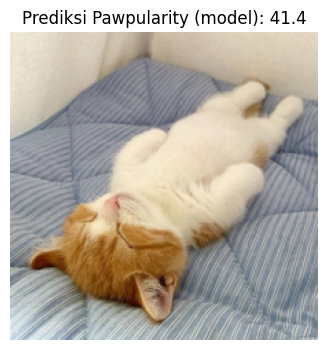

Model yang dipakai: model
Prediksi Pawpularity: 41.4 (skor 0-100)


In [9]:
# === Uji Prediksi Pawpularity dengan Foto Hewan Peliharaan
from google.colab import files
import tensorflow as tf
import numpy as np
from PIL import Image
import io, os
import matplotlib.pyplot as plt

print("Upload 1 gambar hewan peliharaan (jpg/png). Setelah upload, sel akan memproses dan menampilkan prediksi Pawpularity.")
uploaded = files.upload()

if len(uploaded) == 0:
    print("Tidak ada file yang diupload. Jalankan ulang sel dan pilih file.")
else:
    fname = list(uploaded.keys())[0]
    img = Image.open(io.BytesIO(uploaded[fname])).convert('RGB')

    try:
        IMG_SIZE
    except NameError:
        IMG_SIZE = 224

    img_resized = img.resize((IMG_SIZE, IMG_SIZE))
    img_arr = np.array(img_resized).astype(np.float32) / 255.0
    inp = tf.expand_dims(img_arr, 0)

    # Pilih model regresi Pawpularity: best_reg_model, model_e3, model_r50, model_nv, model_multi, atau model (checkpoint sebelumnya)
    model_candidates = ['best_reg_model','model_e3','model_r50','model_nv','model_multi','model','model_aug']
    paw_model = None
    chosen_name = None
    for name in model_candidates:
        if name in globals() and globals()[name] is not None:
            paw_model = globals()[name]
            chosen_name = name
            break

    if paw_model is None:
        print("Tidak menemukan model Pawpularity terlatih di runtime. Jalankan sel pelatihan Pawpularity (mis. sel D3 di sebelumnya).")
    else:
        # beberapa model menerima multi-input (image + brightness)
        try:
            # detect if model expects two inputs by checking input shape or input count
            if isinstance(paw_model.input, list) and len(paw_model.input) == 2:
                # compute brightness scalar
                gray = tf.image.rgb_to_grayscale(img_arr)
                bright = float(tf.reduce_mean(gray).numpy())
                pred = paw_model.predict([inp, np.array([bright])], verbose=0).ravel()[0]
            else:
                # standard single-input
                # try using efficientnet/resnet preprocess if needed based on model name
                if 'efficientnet' in chosen_name or 'e3' in chosen_name:
                    x_in = tf.keras.applications.efficientnet.preprocess_input(inp * 255.0)
                elif 'resnet' in chosen_name:
                    x_in = tf.keras.applications.resnet.preprocess_input(inp * 255.0)
                else:
                    x_in = inp
                pred = paw_model.predict(x_in, verbose=0).ravel()[0]
        except Exception:
            # fallback raw predict
            pred = paw_model.predict(inp, verbose=0).ravel()[0]

        plt.figure(figsize=(6,4))
        plt.imshow(img_resized)
        plt.axis('off')
        plt.title(f"Prediksi Pawpularity ({chosen_name}): {pred:.1f}")
        plt.show()

        print(f"Model yang dipakai: {chosen_name}")
        print(f"Prediksi Pawpularity: {pred:.1f} (skor 0-100)")
